In this notebook, we download a PDB structure and load it to this notebook. Then, we simulate AFM process by a dilation from the given tip shape, creating AFM test data for blind tip reconstruction.

# Download a structure and load it to this notebook

In [38]:
using Plots, HTTP, DelimitedFiles, Statistics
using Revise, MDToolbox
ENV["COLUMNS"] = 150; #display width for MDToolbox

In [39]:
#download("https://files.rcsb.org/download/1OE9.pdb", "./1OE9.pdb")
download("https://files.rcsb.org/download/1OE9.pdb", "./6BNO.pdb")

"./6BNO.pdb"

In [40]:
#t = mdload("1OE9.pdb")
t = mdload("6BNO.pdb")
t = t["protein and chain A"]
decenter!(t)

1x1 TrjArray{Float64, Int64}
|     2.09     0.46    50.94 |

# DilationによるAFMのエミュレーション

In [41]:
# 針や解像度のパラメータの設定
width = 15
height = 15
resolution = 15
radius = 25.0
angle = 10.0
param = AfmizeConfig(angle * (pi / 180),
        radius, 
        MDToolbox.Point2D(-height * resolution, -width * resolution), 
        MDToolbox.Point2D(height * resolution, width * resolution), 
        MDToolbox.Point2D(resolution, resolution), 
        MDToolbox.defaultParameters())

AfmizeConfig(0.17453292519943295, 25.0, MDToolbox.Point2D{Int64}(-225, -225), MDToolbox.Point2D{Int64}(225, 225), MDToolbox.Point2D{Int64}(15, 15), Dict("SI" => 2.1, "CH1" => 1.7, "CZ3" => 1.7, "C" => 1.7, "CH" => 1.7, "ND2" => 1.55, "NE1" => 1.55, "MG" => 1.73, "P" => 1.8, "GLY" => 2.25…))

(xc, yc) = (4, 4)


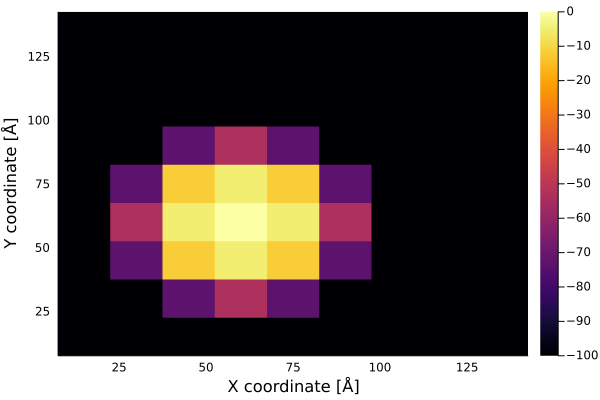

In [42]:
tip = zeros(Float64, 9, 9)
MDToolbox.afmize!(tip, param)

tip_parachuting = zeros(Float64, 9, 9)
tip_parachuting .= -1000000.0
slope = -10.0
xc, yc = MDToolbox.compute_xc_yc(tip)
for i = xc:9
    tip_parachuting[4, i] = (i - xc) .* slope
end

heatmap(collect(1:9) .* resolution, collect(1:9) .* resolution, tip, clim=(-100, 0))
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

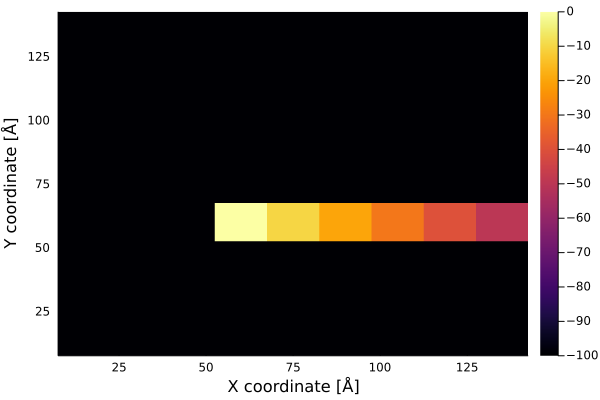

In [43]:
heatmap(collect(1:9) .* resolution, collect(1:9) .* resolution, tip_parachuting, clim=(-100, 0))
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

In [44]:
q = readdlm("../quaternion/QUATERNION_LIST_576_Orient");

In [45]:
using Random

models = t[0, :]
surfs = []
surfs_parachuting = []
images = []

for i in randperm(MersenneTwister(777), 576)
    t_rotated = MDToolbox.rotate(t, q[i, :])
    surf = MDToolbox.surfing(t_rotated, param)    
    surf_parachuting = idilation(surf, tip_parachuting)
    image = idilation(surf_parachuting, tip)
    models = vcat(models, t_rotated)
    push!(surfs, surf)
    push!(surfs_parachuting, surf_parachuting)
    push!(images, image)
end    

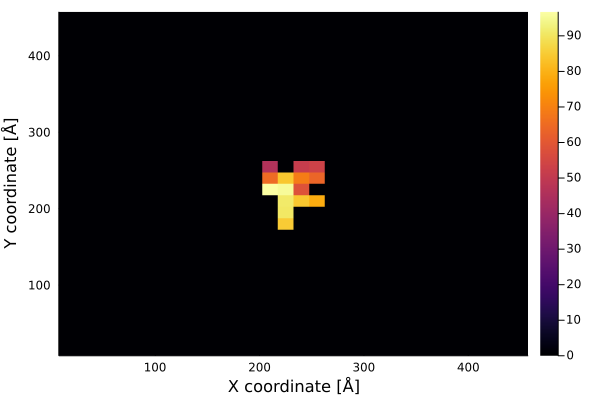

In [46]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, surfs[10])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

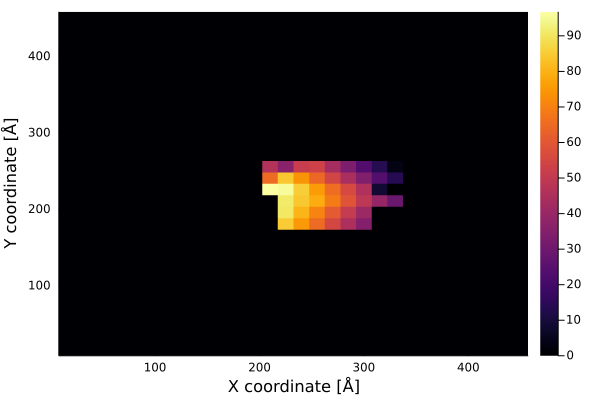

In [47]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, surfs_parachuting[10])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

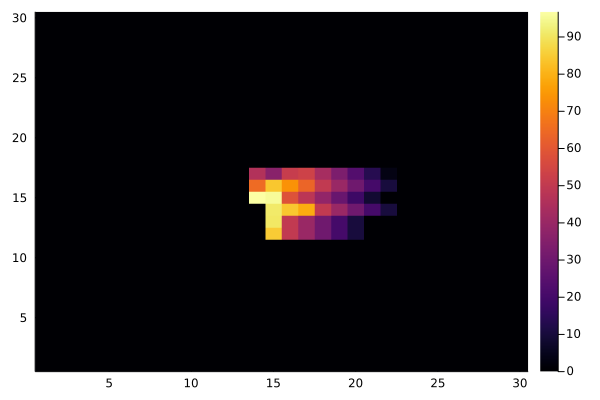

In [49]:
heatmap(ierosion(surfs_parachuting[10], tip_parachuting[:, :]))

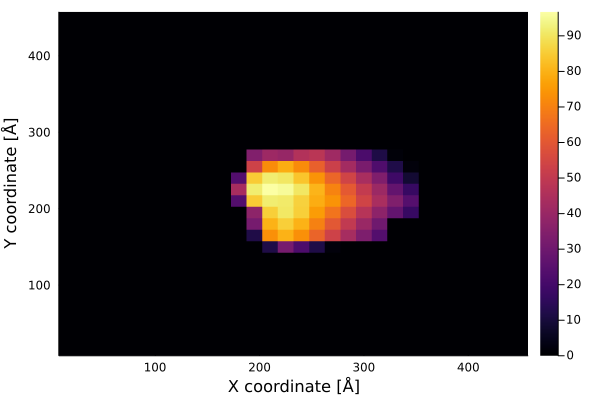

In [50]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, images[10])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

In [51]:
images_randn = deepcopy(images)

for i in 1:length(images)
    images_randn[i] .= images[i] .+ 3.0 * randn(eltype(images[i]), size(images[i]))
end

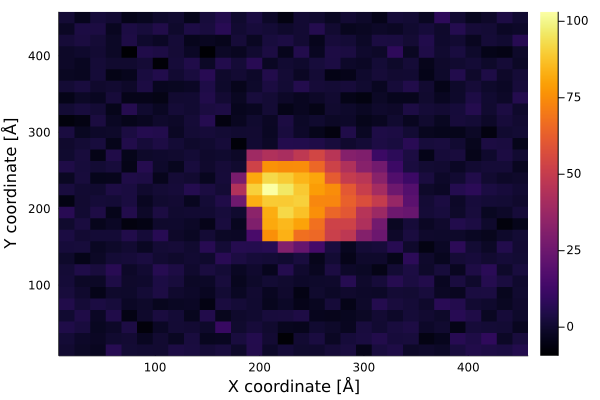

In [52]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, images_randn[10])
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)

In [53]:
using BSON: @save, @load
@save "prepare_test_data.bson" width height resolution radius angle param models tip tip_parachuting surfs surfs_parachuting images images_randn

In [54]:
mdsave("models.pdb", models)

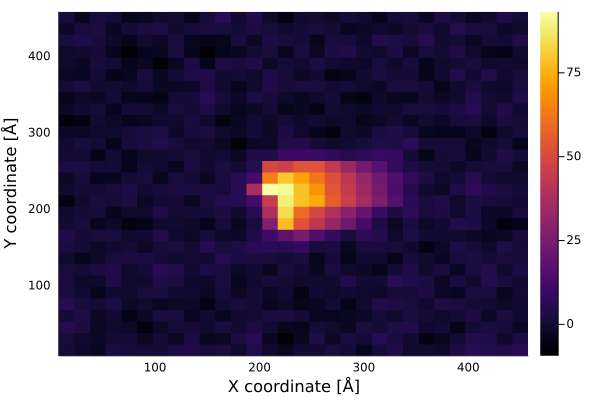

In [55]:
heatmap(collect(1:30) .* resolution, collect(1:30) .* resolution, ierosion(ierosion(images_randn[10], tip), tip_parachuting))
xlabel!("X coordinate [Å]", fontsize=35)
ylabel!("Y coordinate [Å]", fontsize=35)
#xlims!(100, 380)
#ylims!(100, 380)